# Vehicle Detection and Tracking

## Project 5 : Udacity Self Driving Car Engineer Nanodegree

Vehicle Detection and Tracking

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [29]:
import numpy as np
import cv2
import glob
from collections import deque
import time
import pickle

from moviepy.editor import VideoFileClip
from scipy import signal
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

from Advanced_Lane_Finding import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

### Read and display the vehicle and non-vehicle images

In [30]:
# Read the images

images_car  = glob.glob('training_dataset/vehicles/**/*.png')
images_non_car = glob.glob('training_dataset/non-vehicles/**/*.png')
print("Number of images in Car category: ", len(images_car) )
print("Number of images in Non-Car category:  ", len(images_non_car))

Number of images in Car category:  8792
Number of images in Non-Car category:   8968


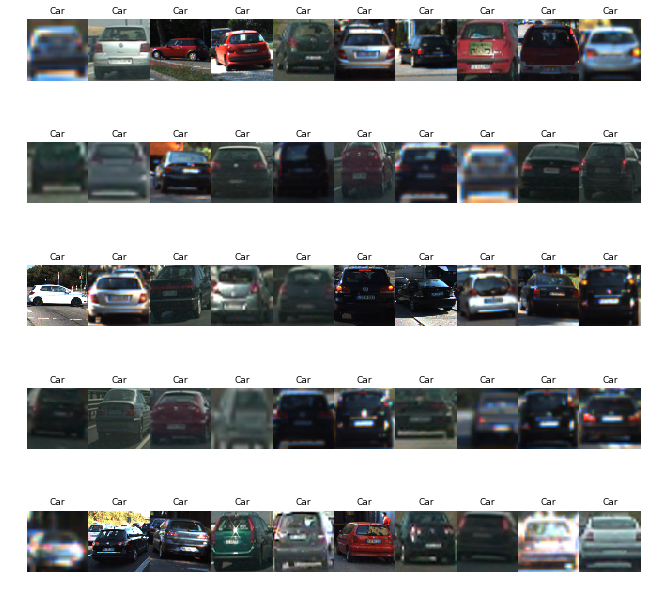

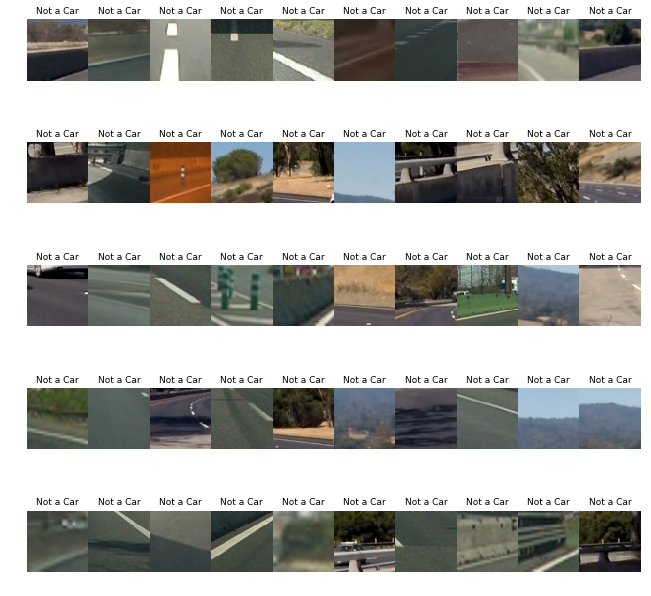

In [31]:
_, ax1 = plt.subplots(5,10, figsize=(11, 11))
_.subplots_adjust(hspace = .15, wspace=.0015)
_plt = ax1.ravel()

# Display the images categorized as vehicles
for i in np.arange(50):
    img = cv2.imread(images_car[np.random.randint(0,len(images_car))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    _plt[i].axis('off')
    _plt[i].set_title('Car', fontsize=9)
    _plt[i].imshow(img)

    
_, ax1 = plt.subplots(5,10, figsize=(11, 11))
_.subplots_adjust(hspace = .15, wspace=.0015)
_plt = plt.figure()
_plt = ax1.ravel()

# Display the image categorized as non-vehicles
for i in np.arange(50):
    img = cv2.imread(images_non_car[np.random.randint(0,len(images_non_car))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    _plt[i].axis('off')
    _plt[i].set_title('Not a Car', fontsize=9)
    _plt[i].imshow(img)

In [32]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        hog_features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return hog_features, hog_image
    # Otherwise call with one output
    else:      
        hog_features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return hog_features

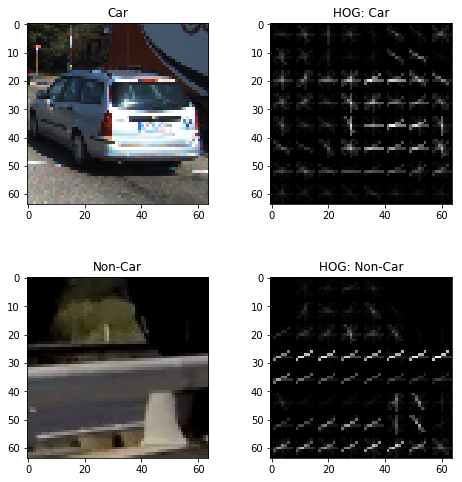

In [33]:
# Images classified as car
car_img = mpimg.imread(images_car[np.random.randint(0,len(images_car))])
_, car_dst = get_hog_features(car_img[:,:,2], 8, 8, 8, vis=True, feature_vec=True)

# Images classified as non-car
noncar_img = mpimg.imread(images_non_car[np.random.randint(0,len(images_non_car))])
_, noncar_dst = get_hog_features(noncar_img[:,:,2], 8, 8, 8, vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8,8))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car', fontsize=12)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('HOG: Car', fontsize=12)
ax3.imshow(noncar_img)
ax3.set_title('Non-Car', fontsize=12)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('HOG: Non-Car', fontsize=12)

In [34]:
# Define a function to extract features from a list of image locations
# This function could also be used to call bin_spatial() and color_hist() (as in the lessons) to extract
# flattened spatial color features and color histogram features and combine them all (making use of StandardScaler)
# to be used together for classification

def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

#### Train the SVC classifier

In [35]:
# Feature extraction parameters
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t = time.time()
car_features = extract_features(images_car, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(images_non_car, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)  

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))


103.18 Seconds to extract HOG features...
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188


In [36]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

2.09 Seconds to train SVC...
Test Accuracy of SVC =  0.9811
My SVC predicts:  [ 1.  1.  0.  1.  1.  0.  1.  0.  0.  0.]
For these 10 labels:  [ 1.  1.  0.  1.  1.  0.  1.  0.  0.  0.]
0.03102 Seconds to predict 10 labels with SVC


The method detects objects (cars) by extracting features using HOG and then make predictions


In [37]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def single_img_features(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    feature_image = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(feature_image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(feature_image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(feature_image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(feature_image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(feature_image, cv2.COLOR_RGB2YCrCb)
        elif cspace == 'GRAY':
            ctrans_tosearch = cv2.cvtColor(feature_image, cv2.COLOR_RGB2GRAY)
    else: ctrans_tosearch = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            hog_features = hog_features.reshape(1,-1)
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

In [38]:
test_img = mpimg.imread('./test_images/test5.jpg')

ystart = 400
ystop = 656
scale = 1.5
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

rectangles = single_img_features(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None)

print(len(rectangles), 'rectangles found in image')

4 rectangles found in image


In [39]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

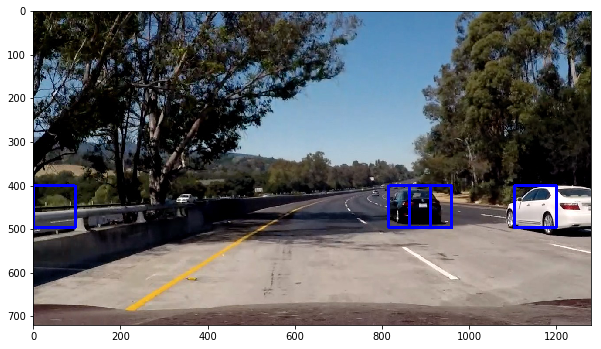

In [40]:
test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

Number of boxes:  78


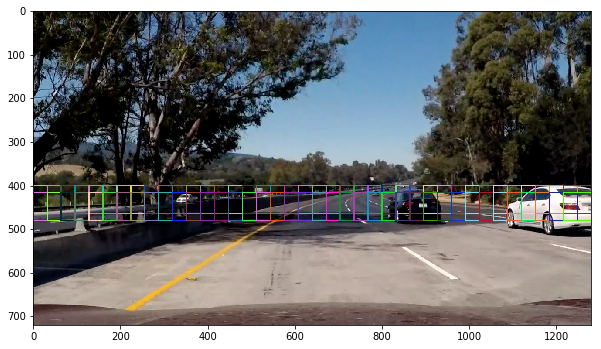

In [41]:
test_img = mpimg.imread('./test_images/test5.jpg')

rects = []

ystart = 400
ystop = 464
scale = 1.0
rects.append(single_img_features(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))
ystart = 416
ystop = 480
scale = 1.0
rects.append(single_img_features(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

Number of boxes:  50


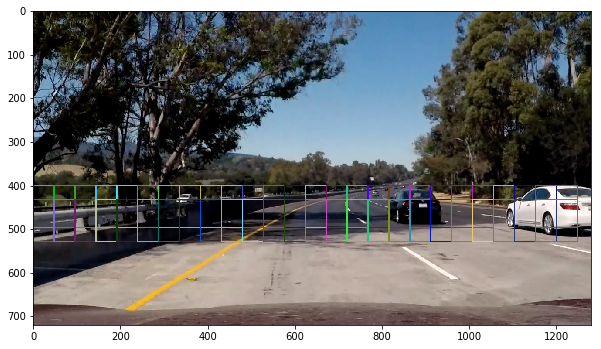

In [42]:
test_img = mpimg.imread('./test_images/test5.jpg')

rects = []

ystart = 400
ystop = 496
scale = 1.5
rects.append(single_img_features(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))
ystart = 432
ystop = 528
scale = 1.5
rects.append(single_img_features(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

Number of boxes:  38


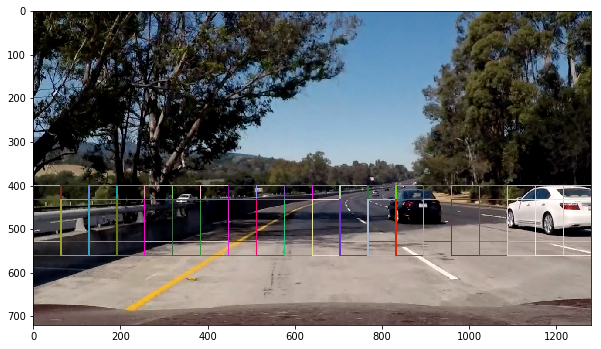

In [43]:
test_img = mpimg.imread('./test_images/test5.jpg')

rects = []

ystart = 400
ystop = 528
scale = 2.0
rects.append(single_img_features(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))
ystart = 432
ystop = 560
scale = 2.0
rects.append(single_img_features(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

Number of boxes:  24


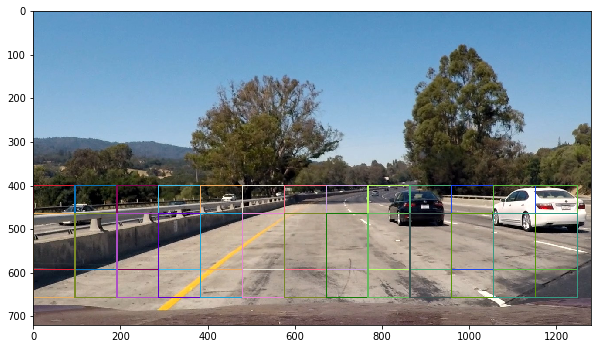

In [44]:
test_img = mpimg.imread('./test_images/test1.jpg')

rects = []

ystart = 400
ystop = 596
scale = 3.0
rects.append(single_img_features(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))
ystart = 464
ystop = 660
scale = 3.0
rects.append(single_img_features(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

In [45]:

colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

y_start = [
    400,
    416,
    400,
    432,
    400,
    432,
    400,
    464
]

y_stop = [
    464,
    480,
    496,
    528,
    528,
    560,
    596,
    660
]

scale = [
    1.0,
    1.0,
    1.5,
    1.5,
    2.0,
    2.0,
    3.5,
    3.5
]

In [46]:
def define_rectangles(test_img, isGetRectangles=False):
    
    rectangles = []

    rectangles.append(single_img_features(test_img, y_start[0], y_stop[0], scale[0], colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    rectangles.append(single_img_features(test_img, y_start[1], y_stop[1], scale[1], colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    rectangles.append(single_img_features(test_img, y_start[2], y_stop[2], scale[2], colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    rectangles.append(single_img_features(test_img, y_start[3], y_stop[3], scale[3], colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    rectangles.append(single_img_features(test_img, y_start[4], y_stop[4], scale[4], colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    rectangles.append(single_img_features(test_img, y_start[5], y_stop[5], scale[5], colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    rectangles.append(single_img_features(test_img, y_start[6], y_stop[6], scale[6], colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    rectangles.append(single_img_features(test_img, y_start[7], y_stop[7], scale[7], colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    # apparently this is the best way to flatten a list of lists
    rectangles = [item for sublist in rectangles for item in sublist] 
    test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
    
    if isGetRectangles:
        return test_img_rects, rectangles
    else:
        return test_img_rects

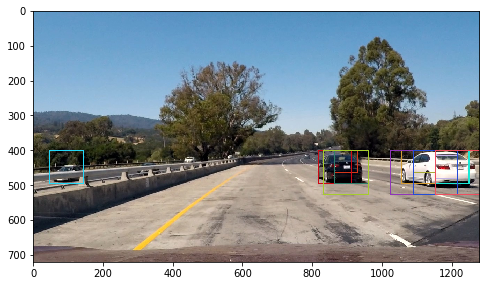

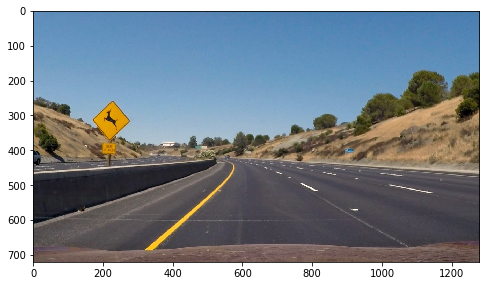

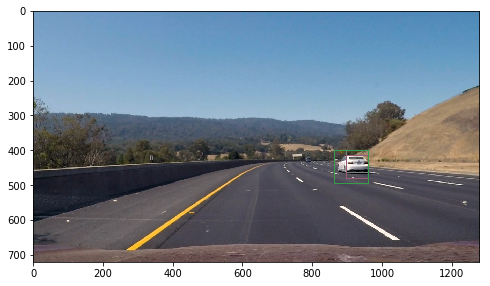

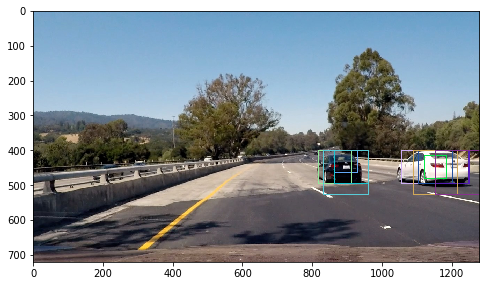

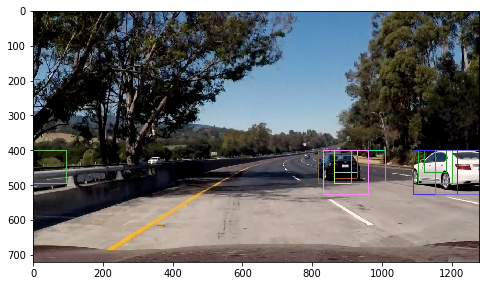

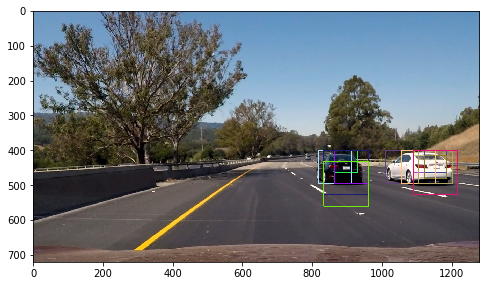

In [47]:
test_images  = glob.glob('test_images/*')

for file in test_images:
    test_img = mpimg.imread(file)
    image_with_rects=define_rectangles(test_img)
    plt.figure(figsize=(8,8))
    plt.imshow(image_with_rects)

In [48]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

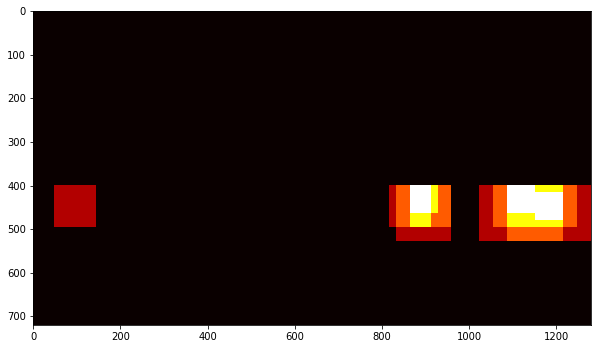

In [49]:
# Test out the heatmap
test_img = mpimg.imread('./test_images/test1.jpg')
heatmap_img = np.zeros_like(test_img[:,:,0])
_, rectangles = define_rectangles(test_img, isGetRectangles=True)
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

In [50]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

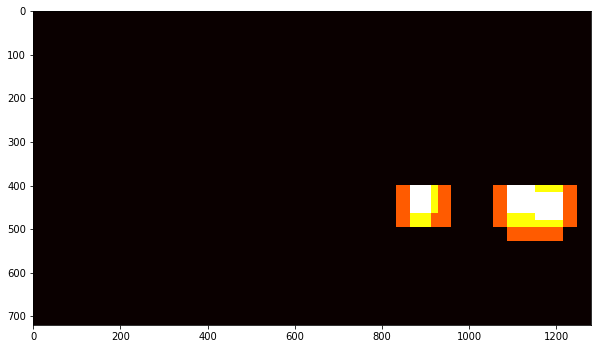

In [51]:
heatmap_img = apply_threshold(heatmap_img, 1)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

2 cars found


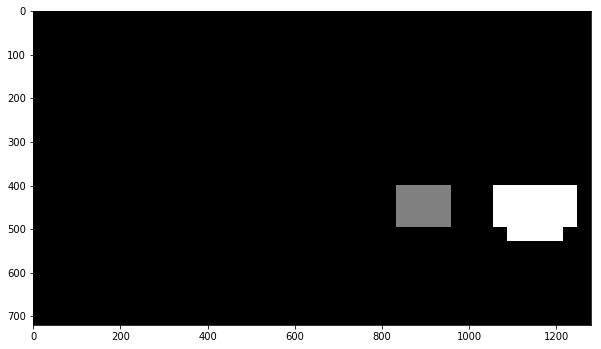

In [52]:
labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

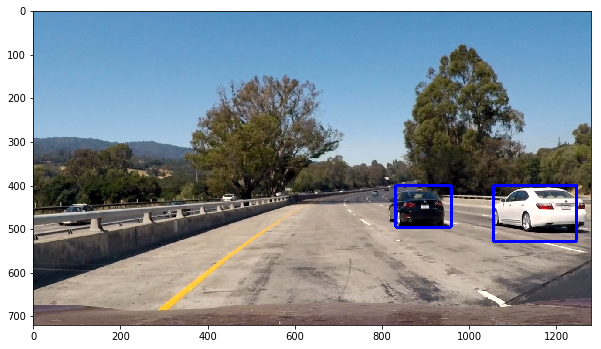

In [53]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

In [54]:
# Constants

colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

y_start = [
    400,
    416,
    400,
    432,
    400,
    432,
    400,
    464
]

y_stop = [
    464,
    480,
    496,
    528,
    528,
    560,
    596,
    660
]

_scale = [
    1.0,
    1.0,
    1.5,
    1.5,
    2.0,
    2.0,
    3.5,
    3.5
]

In [57]:
def process_frame(img):

    rectangles = []
    
    rectangles.append(single_img_features(img, y_start[0], y_stop[0], _scale[0], colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    rectangles.append(single_img_features(img, y_start[1], y_stop[1], _scale[1], colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    rectangles.append(single_img_features(img, y_start[2], y_stop[2], _scale[2], colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    rectangles.append(single_img_features(img, y_start[3], y_stop[3], _scale[3], colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
 
    rectangles.append(single_img_features(img, y_start[4], y_stop[4], _scale[4], colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    rectangles.append(single_img_features(img, y_start[5], y_stop[5], _scale[5], colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    rectangles.append(single_img_features(img, y_start[6], y_stop[6], _scale[6], colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    rectangles.append(single_img_features(img, y_start[7], y_stop[7], _scale[7], colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    rectangles = [item for sublist in rectangles for item in sublist] 
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    #cv2.imwrite("original6.png", img)
    #cv2.imwrite("heatmap6.png", np.multiply(heatmap_img,155))
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return video_pipeline(draw_img)

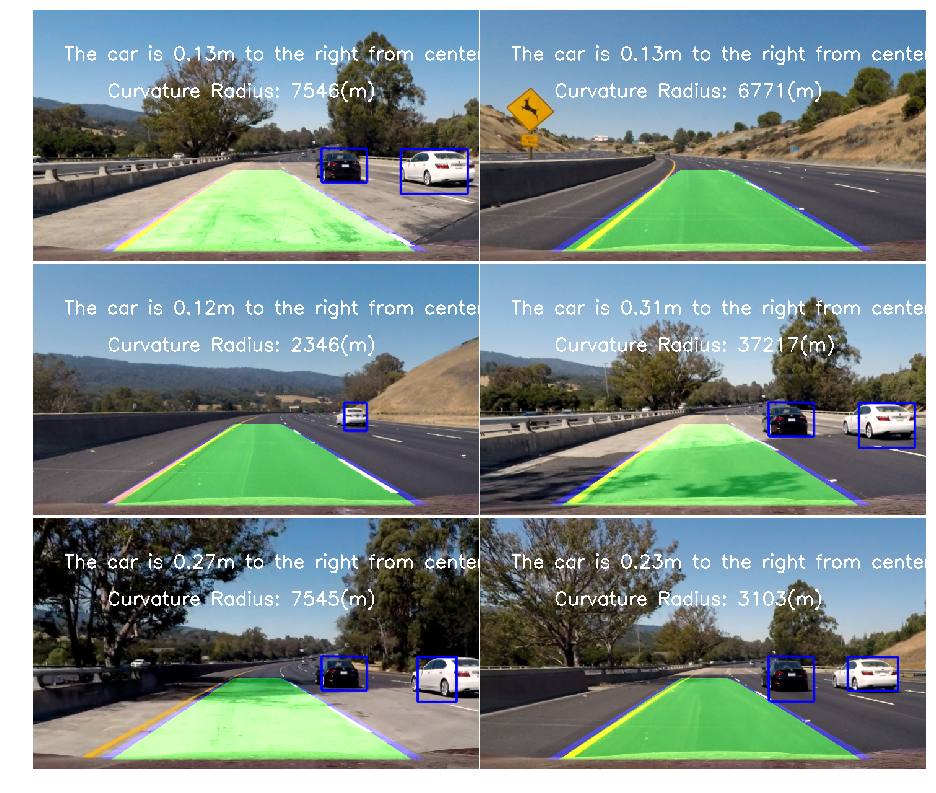

In [58]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_frame(mpimg.imread(im)))
    axs[i].axis('off')


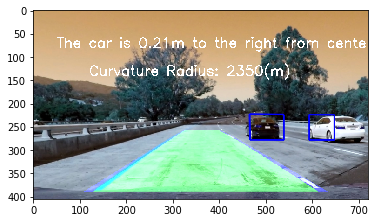

In [59]:
from Advanced_Lane_Finding import *

# Read a test image to check the pipeline
img = cv2.imread("test_images/test1.jpg")
plt.imshow(process_frame(img))

In [60]:
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [01:34<00:02,  2.43s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

Wall time: 1min 35s


In [63]:
# Define a class to store data from video
class DetectedObjects():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_box = [] 
        
    def apply_box(self, boxes):
        self.prev_box.append(boxes)
        if len(self.prev_box) > 15:
            # throw out oldest rectangle set(s)
            self.prev_box = self.prev_box[len(self.prev_box)-15:]

In [64]:
def process_frame_for_video(img):

    rectangles = []
    
    rectangles.append(single_img_features(img, y_start[0], y_stop[0], _scale[0], colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    rectangles.append(single_img_features(img, y_start[1], y_stop[1], _scale[1], colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    rectangles.append(single_img_features(img, y_start[2], y_stop[2], _scale[2], colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    rectangles.append(single_img_features(img, y_start[3], y_stop[3], _scale[3], colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
 
    rectangles.append(single_img_features(img, y_start[4], y_stop[4], _scale[4], colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    rectangles.append(single_img_features(img, y_start[5], y_stop[5], _scale[5], colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    rectangles.append(single_img_features(img, y_start[6], y_stop[6], _scale[6], colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    rectangles.append(single_img_features(img, y_start[7], y_stop[7], _scale[7], colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

 
    rectangles = [item for rect in rectangles for item in rect] 
    
    # Additional check for video frames processing
    if len(rectangles) > 0:
        d_objs.apply_box(rectangles)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    for rects in d_objs.prev_box:
        heatmap_img = add_heat(heatmap_img, rects)
    heatmap_img = apply_threshold(heatmap_img, 1 + len(d_objs.prev_box)//2)
     
    labels = label(heatmap_img)
    draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
    return video_pipeline(draw_img)

In [65]:
d_objs = DetectedObjects()

test_out_file = 'project_video_out.mp4'
clip_test = VideoFileClip('project_video.mp4')#.subclip(15,20)
clip_test_out = clip_test.fl_image(process_frame_for_video)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [48:00<00:02,  2.34s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 48min 1s
